# Image Captioning Using ViT and GPT2 Transformers

   * [Self-link](https://github.com/foobar167/junkyard/blob/master/fine_tuning/Image_Captioning_with_ViT_and_GPT2.ipynb)
   * Completion time for this notebook is **3:00 hours** or 1 hour for 1 epoch, total 3 epochs. GPU: `GeForce GTX TITAN X`.

Image captioning using Transformers is a technique that generates natural language descriptions of an image by combining vision Transformers (ViT) for image understanding and language Transformers for text generation.

![Image Captioning Task Scheme](./data/Image_Captioning_scheme.png)

This approach leverages the self-attention mechanism in Transformers to capture both global image context and linguistic structure, resulting in more accurate and coherent captions compared to older CNN-RNN methods. Examples include models like Vision-Encoder with Language-Decoder (VELD), BLIP, and Flamingo. It’s a powerful example of multimodal AIbridging vision and language through Transformer architectures.

The [Vision Encoder Decoder Model](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder) can be used to initialize an image-to-text model with any pre-trained Transformer-based vision model as the encoder (e.g. ViT, BEiT, DeiT, Swin) and any pre-trained language model as the decoder (e.g. RoBERTa, GPT2, BERT, DistilBERT).

![Vision Encoder Decoder Architecture](./data/vision-encoder-decoder.png)

The **Vision Transformer**, or ViT, is a model for image classification that employs a Transformer-like architecture over patches of the image. An image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. In order to perform classification, the standard approach of adding an extra learnable “classification token” to the sequence is used.

The ViT was first introduced in paper [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/pdf/2010.11929.pdf). The ViT was created to perform similar tasks of an NLP based transformer. Instead of token for words, fixed sized patches are used in image that are subset of images.

![ViT architecture](./data/ViT_architecture.png)

The ViT model we are using has been pre-trained on the public ImageNet-21k dataset. The goal is to demonstrate **fine-tunning ViTs**, for generating image captions without the necessity of retraining from scratch.

![ImageNet-21k dataset](./data/ImageNet-21k_dataset.png)

The **GPT-2**, or **Generative Pre-trained Transformer 2** model pretrained on a very large corpus of English data in a self-supervised fashion. Inputs are sequences of continuous text of a certain length and the targets are the same sequence, shifted one token (word or piece of word) to the right. The model uses internally a mask-mechanism to make sure the predictions for the token i only uses the inputs from 1 to i but not the future tokens. This way, the model learns an inner representation of the English language that can then be used to extract features useful for downstream tasks. The model is best at what it was pretrained for however, which is generating texts from a prompt. Unlike models that use both encoder and decoder (like T5 or BERT), **GPT-2 uses only the decoder part of the original Transformer**, modified to process text autoregressively  meaning it predicts the next word based on previous words.

[DistilGPT2](https://huggingface.co/distilbert/distilgpt2) (short for Distilled-GPT2) is an English-language model pre-trained with the supervision of the smallest version of Generative Pre-trained Transformer 2 (GPT-2). Like GPT-2, DistilGPT2 can be used to generate text.

Links:   
   * [Vision Encoder Decoder (ViT + GPT2) model that fine-tuned on flickr8k-dataset for image-to-text task](https://huggingface.co/atasoglu/vit-gpt2-flickr8k) - minimal implementation details. [My example is here](Image_Captioning_with_Min_Detailes.ipynb)
   * [The Illustrated Image Captioning using transformers](https://ankur3107.github.io/blogs/the-illustrated-image-captioning-using-transformers/) - moderate implementation details
   * [Image Caption Model from scratch  ViT+GPT](https://medium.com/@mr.sk12112002/image-caption-model-from-scratch-vit-gpt-94afaae30fb7) - much more detailed implementation of code blocks
   * [Image Captioning : ViT + GPT2](https://www.kaggle.com/code/burhanuddinlatsaheb/image-captioning-vit-gpt2) (Kaggle) - additional info


# Helper Functions and Libraries

In [41]:
# Set only one visible GPU. Turn off Huggingface trainer DataParallel
GPU = 0  # GPU number. After change, restart the kernel

%set_env CUDA_VISIBLE_DEVICES={GPU}

env: CUDA_VISIBLE_DEVICES=0


In [42]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():  # make sure GPU is available
    num = torch.cuda.device_count()
    print(f"GPU count: {num}")
    for i in range(num):
        print(f"GPU {i} name: {torch.cuda.get_device_name(i)}")
else:
    print("GPU is not available")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU count: 1
GPU 0 name: NVIDIA GeForce GTX 1080 Ti


In [43]:
import os
import gc  # gabbage collector
import nltk  # Natural Language Toolkit
import math
import random
import shutil
import requests  # download images using URL
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt

# PyTorch libraries
import torch
import torchvision.transforms as t

# Hugging Face libraries
import datasets
import evaluate
import transformers as hf

from PIL import Image
from io import BytesIO
from itertools import islice
from functools import partial


def set_seed(seed: int = 42):
    """ Set random seed for reproducibility """
    random.seed(seed)
    hf.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False


def show_trainable_layers(model):
    """ Show trainable layers of the model """
    train_params = 0  # number of trainable parameters
    layers = []  # names of trainable layers
    for name, param in model.named_parameters():
        if param.requires_grad:  # if trainable layer
            train_params += param.numel()
            layers.append(name)
    print(f"Number of trainable parameters = {train_params:,}")
    print("Trainable layers:\n")
    print(*layers, sep="\n")


set_seed()

CPU = multiprocessing.cpu_count()
NUM_WORKERS = math.ceil(CPU*2/3)
print(f"Number of CPU cores: {CPU}")
print(f"Number of worker cores: {NUM_WORKERS}")

DEVICE = f"cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
if "cuda" in DEVICE:
    # Get the index of the current CUDA device
    current_device_index = torch.cuda.current_device()
    # Get the name of the current CUDA device
    device_name = torch.cuda.get_device_name(current_device_index)
    print(f"Current CUDA device name: {device_name}")
else:
    print("CUDA is not available. Using CPU")

# Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes)
# at resolution 224x224.
ENCODER = "google/vit-base-patch16-224-in21k"

# DistilGPT2 (short for Distilled-GPT2) is an English-language model pre-trained with
# the supervision of the smallest version of Generative Pre-trained Transformer 2 (GPT-2).
DECODER = "distilgpt2"

# Checking different options:

# * Option 1. Freeze all encoder layers
# * Option 2. Freeze all encoder layers except the last one
# * Option 3. Unfreeze all layers of the model
# * Option 4. Unfreeze all layers of the model. Make one caption from 5 different captions
# * Option 5. The same as option 3, but reduce MAX_TOKENS from 50 to 20
# * Option 6. The same as option 4, but increase MAX_TOKENS from 50 to 132
#    * 6.1. Static augmentation (augment 1 time at the beginning)
#    * 6.2. Without augmentation
#    * 6.3. Augmentation on-the-fly (dynamic augmentation)
#    * 6.4. ROUGE-L F1 score instead of default cross-entropy loss
# * Option 7. The same as 6.4, but with texts augmentation.

OPTION = 6  # can be from 1 to 6
TEMP = "temp"  # path to temporal directory with data
RESULTS = f"{TEMP}/results-{OPTION}"  # directory with checkpoints
TRAIN_CSV, VALID_CSV = f"{TEMP}/captions.csv", f"{TEMP}/captions_val.csv"
DS_NAME = f"{TEMP}/flickr8k_huggingface_dataset"

os.makedirs(TEMP, exist_ok=True)  # create temporal directory
print(f"Checking option: {OPTION}")
print(f"Save model checkpoints to '{RESULTS}'")

NUM_VAL = 500  # number of validation images in evaluation dataset
MIN_CAPTION_LENGTH = 2  # minimum caption length in chars

# In Flickr8k dataset the longest caption has length 199
# MAX_CAPTION_LENGTH = 199  # not in use

# Article: What are tokens and how to count them
# URL: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
if OPTION == 5:
    MAX_TOKENS = 20  # 1 token ≈ 4 chars (approximately)
if OPTION == 6:
    MAX_TOKENS = 132  # the longest caption has length 527 chars ≈ 132 tokens
else:
    MAX_TOKENS = 50  # 50 tokens ≈ 200 chars (approximately)

EPOCHS = 16  # 3

if OPTION in (1, 2, ):
    BATCH_SIZE = 100
elif OPTION in (3, 4, 5, ):
    BATCH_SIZE = 40
elif OPTION in (6, ):
    BATCH_SIZE = 25  # MAX_TOKENS require more memory
else:
    BATCH_SIZE = 25

# To remove tokenizers directory
# cd ~/nltk_data/tokenizers  # navigate to the tokenizers directory
# rm -rf punkt.zip punkt  # remove the punkt.zip file and directory
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)
    nltk.download("punkt_tab", quiet=True)

Number of CPU cores: 12
Number of worker cores: 8
Using device: cuda
Current CUDA device name: NVIDIA GeForce GTX 1080 Ti
Checking option: 6
Save model checkpoints to 'temp/results-6'


# A Quick Guide to Tokenization

[Demystifying Tokenization: Preparing Data for Large Language Models (LLMs)](https://www.linkedin.com/pulse/demystifying-tokenization-preparing-data-large-models-rany-2nebc).

[How tokenizers work in AI models: A beginner-friendly guide](https://nebius.com/blog/posts/how-tokenizers-work-in-ai-models)

In [4]:
# Also, try "openai-community/gpt2"
tokenizer = hf.GPT2Tokenizer.from_pretrained(DECODER)

text = "Hello World! This is a test message."

tokenized_text = tokenizer(text)
encoded_text = tokenized_text["input_ids"]
decoded_text = tokenizer.decode(encoded_text)

print(tokenized_text)
print(f"Encoded text: {encoded_text}\n")
print(f"Decoded tokens back into text:\n\t{decoded_text}\n")

list_texts = ["Hi, how are you?", "I'm good", "Yes"]
encoded_texts = tokenizer(list_texts)["input_ids"]
print(f"Encoded several texts: {encoded_texts}\n")

# This line of code sets the tokenizer's pad token to be the same as its EOS token.
# This means that the same token will be used both to pad shorter sequences
# and to signify the end of a sequence.
# GPT2 only has bos/eos tokens but not decoder_start/pad tokens
tokenizer.pad_token = tokenizer.eos_token  # pad with EOS token

encoded_texts_longest = tokenizer(list_texts, padding=True)["input_ids"]
print(f"Using padding: {encoded_texts_longest}\n")

encoded_texts_truncation = tokenizer(
    list_texts, max_length=3, truncation=True)["input_ids"]
print(f"Using truncation: {encoded_texts_truncation}\n")

tokenizer.truncation_side = "left"  # truncate left side
encoded_texts_truncation_left = tokenizer(
    list_texts, max_length=3, truncation=True)["input_ids"]
print(f"Using left-side truncation: {encoded_texts_truncation_left}\n")

tokenizer.truncation_side = "right"  # truncate right side
truncation_padding = tokenizer(
    list_texts, max_length=3, truncation=True, padding=True)["input_ids"]
print(f"Using both truncation and padding: {truncation_padding}\n")

decoded_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in encoded_texts]
print(f"Decoded texts: {decoded_texts}\n")

{'input_ids': [15496, 2159, 0, 770, 318, 257, 1332, 3275, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}
Encoded text: [15496, 2159, 0, 770, 318, 257, 1332, 3275, 13]

Decoded tokens back into text:
	Hello World! This is a test message.

Encoded several texts: [[17250, 11, 703, 389, 345, 30], [40, 1101, 922], [5297]]

Using padding: [[17250, 11, 703, 389, 345, 30], [40, 1101, 922, 50256, 50256, 50256], [5297, 50256, 50256, 50256, 50256, 50256]]

Using truncation: [[17250, 11, 703], [40, 1101, 922], [5297]]

Using left-side truncation: [[389, 345, 30], [40, 1101, 922], [5297]]

Using both truncation and padding: [[17250, 11, 703], [40, 1101, 922], [5297, 50256, 50256]]

Decoded texts: ['Hi, how are you?', "I'm good", 'Yes']



# Loading and Processing the Dataset

[Flickr 8k Dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k) is a new benchmark collection for sentence-based image description and search, connsisting of 8,091 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations.

In [5]:
# Download and unzip Flickr8k dataset
if os.path.exists(f"{TEMP}/flickr8k"):
    pass  # already downloaded
else:
    URL = "https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip"
    !wget -P "{TEMP}" -N "{URL}"
    !unzip -q "{TEMP}/flickr8k.zip" -d "{TEMP}/flickr8k"

In [6]:
df = pd.read_csv(f"{TEMP}/flickr8k/captions.txt")
display(df.head())  # show first rows
print()
for row in islice(df.itertuples(), 12):  # print first 12 rows
    print(row.image, row.caption)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...


1000268201_693b08cb0e.jpg A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg A girl going into a wooden building .
1000268201_693b08cb0e.jpg A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b742ab4b8.jpg A little

Skip caption "A" for "temp/flickr8k/Images/2428275562_4bde2bc5ea.jpg"
Skip caption "a" for "temp/flickr8k/Images/3640443200_b8066f37f6.jpg"


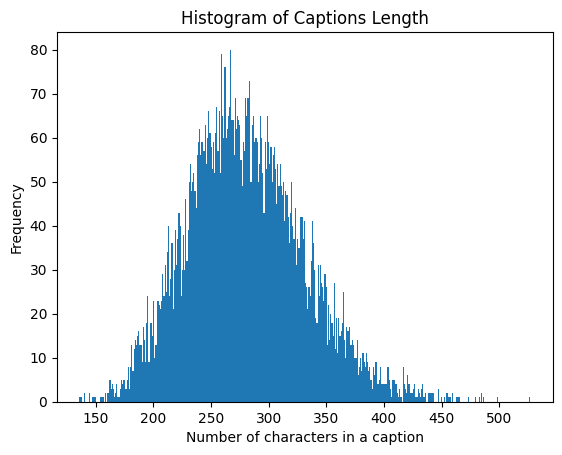


There are 8091 images.

Shortest caption has length 136 for image 'temp/flickr8k/Images/95151149_5ca6747df6.jpg':
	a mountain landscape . a mountainous photo is complete with a blue sky . a snowy mountain range . rocky mountains . snow covered peaks .

Longest caption has length 527 for 'temp/flickr8k/Images/2894217628_f1a4153dca.jpg':
	a holder and kicker for a football team dressed in orange , white and black play while onlookers behind them watch . a kicker launches the football forward while the holder checks his fingers . the football player wearing a white helmet and orange chairs swing his leg while the player next to him kneels . two football player are in the kick off position in front of a crowd . two young men on the same football team are wearing orange and white uniforms and playing on an outside field while coaches and other players watch .

There are 7591 training images.
There are 500 validation images.

Show 2 examples from 0 to 2:
temp/flickr8k/Images/1000268201_693b

In [7]:
def show(captions, num, start=0):
    """
        Show first `num` key-value pairs in captions.
    """
    print(f"Show {num} examples from {start} to {start + num}:")
    # islice(iterable, start, stop, step)
    iterator = iter(captions.items())
    key_value = islice(iterator, start, start + num)
    for key, value in key_value:
        print(f"{key}\t", *value, sep="\n\t")
    print()


def histogram(chars, bins=10):
    """ Create a histogram from a list of integers. """
    plt.hist(chars, bins=bins)  # create the histogram
    # Add labels and a title for clarity
    plt.xlabel("Number of characters in a caption")
    plt.ylabel("Frequency")
    plt.title("Histogram of Captions Length")
    # Display the plot
    plt.show()


image_path = f"{TEMP}/flickr8k/Images"
captions, captions_val = {}, {}  # training and validation captions

# for row in islice(df.itertuples(), 500):  # test first 500 rows for 100 images
for row in df.itertuples():
    image_name = os.path.join(image_path, row.image)
    caption = row.caption  # copy string

    if len(caption) < MIN_CAPTION_LENGTH:
        print(f'Skip caption "{caption}" for "{image_name}"')
        continue  # skip this caption

    # I don't know why, but from GPT-2 all letters are in lowercase
    # caption = caption[0].upper() + caption[1:]  # capitalize the 1st letter
    caption = caption[0].lower() + caption[1:]  # lowercase the 1st letter

    if caption.endswith((" .", " !", " ?", ' "', )):
        pass  # do nothing
    elif caption.endswith((" ,", " '", )):
        caption = caption[:-2]  # remove the final comma or apostrophe from a caption
        caption = caption + " ."  # add the final period to a caption
    else:
        caption = caption + " ."  # add the final period to a caption
    
    if OPTION in (4, 6, ):  # make 1 caption from 5 different captions for each image
        if image_name in captions:
            s = captions[image_name][0]  # get previous caption
            s += " " + caption  # extend previous caption
            captions[image_name] = [s]  # save extended caption
        else:
            captions[image_name] = [caption]
    else:  # there are 5 different captions for each image
        if image_name in captions:
            captions[image_name].append(caption)
        else:
            captions[image_name] = [caption]

shortest, longest = None, None  # shortest and longest captions
shortest_len, longest_len = float("inf"), 0
shortest_name, longest_name = None, None
chars = []  # list of captions length

for key, value in captions.items():  # iterate over key-value pairs
    for caption in value:
        caption_len = len(caption)
        chars.append(caption_len)
        if caption_len < shortest_len:
            shortest, shortest_len, shortest_name = caption, caption_len, key
        if caption_len > longest_len:
            longest, longest_len, longest_name = caption, caption_len, key

bins = longest_len - shortest_len + 1
histogram(chars, bins=bins)  # draw histogram of captions length

print(f"\n" f"There are {len(captions)} images.\n")
print(f"Shortest caption has length {shortest_len} for image '{shortest_name}':"
      f"\n\t" f"{shortest}\n")
print(f"Longest caption has length {longest_len} for '{longest_name}':"
      f"\n\t" f"{longest}\n")

for i in range(min(NUM_VAL, len(captions))):
    key, value = captions.popitem()  # removes and returns the last key-value pair
    captions_val[key] = value  # validation captions

print(f"There are {len(captions)} training images.")
print(f"There are {len(captions_val)} validation images.\n")

show(captions, 2)
show(captions_val, 3)

In [8]:
# For debug purposes. Making small dataset
captions = dict(islice(captions.items(), 300))
captions_val = dict(islice(captions_val.items(), 300))

In [9]:
def get_dataset(captions, csv_file):
    """
        Convert dictionary back to CSV file and then to Huggingface dataset.
        It is OK to have multiple captions per image becuase of data augmentation.
    """
    rows = []
    for key, value in captions.items():
        for caption in value:
            rows.append({"image": key, "caption": caption})

    # There will be no memory overflow if you save the DataFrame to a CSV file
    #   and then create a dataset from the CSV.
    pd.DataFrame(rows).to_csv(csv_file, index=False)  # save dictionary to CSV file
    ds = datasets.Dataset.from_csv(csv_file)  # convert CSV file to Huggingface Dataset

    # # BUG! If you run these two lines of code,
    # #      a memory overflow will occur in Dataset.map function later
    # df = pd.DataFrame(rows)  # from dictionary to Pandas DataFrame
    # ds = datasets.Dataset.from_pandas(df)  # from Pandas Dataframe to Huggingface Dataset

    return ds


train_ds = get_dataset(captions, TRAIN_CSV)
valid_ds = get_dataset(captions_val, VALID_CSV)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Initialize Feature Extractor and Tokenizer

We need image **feature extractor** to convert images to a tensor.

We need text **tokenizer** to convert text to tokens.

In [10]:
# Load feature extractor
feature_extractor = hf.AutoImageProcessor.from_pretrained(ENCODER, use_fast=True)

normalize = t.Normalize(
    mean=feature_extractor.image_mean,
    std=feature_extractor.image_std
)

size = list(feature_extractor.size.values())  # image size
interpolation = t.InterpolationMode.BICUBIC  # for most functions default is BILINEAR

# It is generally NOT recommended to use data augmentation on the validation set
process = t.Compose([
    t.Resize(size, interpolation=interpolation),
    t.ToTensor(),  # convert to pytorch tensor
    normalize,  # normalize pixel values
])


def random_color():
    """ Generate a random fill color (e.g., RGB list) """
    return torch.randint(low=0, high=256, size=(3,), dtype=torch.uint8).tolist()


class random_rotation_with_random_fill:
    """ Fill empty areas with RANDOM RGB color """
    def __call__(self, img):
        fill = random_color()
        return t.RandomRotation(degrees=8,  # (-degrees, +degrees)
                                interpolation=interpolation,
                                fill=fill,
                               )(img)


class random_affine_with_random_fill:
    """
      Define the RandomAffine transform
        degrees - range of degrees for rotation (-8 to +8)
        translate - maximum absolute fraction of the image width/height
                    for translation (e.g., 0.05 means up to 5% shift)
        scale - scaling factor interval (e.g., 0.9 to 1.1 means scaling between 90% and 110%)
        shear - range of degrees for shear transformation (e.g., -5 to +5 along x-axis)
        fill - fill empty areas with RANDOM RGB color
    """
    def __call__(self, img):
        fill = random_color()
        return t.RandomAffine(degrees=8,
                              translate=(0.05, 0.05),
                              scale=(0.9, 1.1),
                              shear=5,
                              # No support for BICUBIC interpolation. Use BILINEAR
                              interpolation=t.InterpolationMode.BILINEAR,
                              fill=fill,
                             )(img)


class random_perspective_with_random_fill:
    """
      Define the RandomPerspective transform
        distortion_scale: controls the degree of distortion (0 to 1)
        p is the probability of applying the transform (0 to 1)
    """
    def __call__(self, img):
        fill = random_color()
        return t.RandomPerspective(distortion_scale=0.1,  # small distortion
                                   p=0.5,  # probability == 1/2
                                   interpolation=interpolation,
                                   fill=fill,
                                  )(img)


transform = t.Compose([
    lambda image: image.convert("RGB"),  # ensure the image is in RGB format
    random_affine_with_random_fill(),
    random_perspective_with_random_fill(),
    random_rotation_with_random_fill(),
    t.RandomHorizontalFlip(),  # flip horizontally with probability 0.5
    
    # Define the ColorJitter transform with small adjustments
    #   brightness: factor from [1-0.1, 1+0.1] = [0.9, 1.1]
    #   contrast: factor from [1-0.1, 1+0.1] = [0.9, 1.1]
    #   saturation: factor from [1-0.1, 1+0.1] = [0.9, 1.1]
    #   hue: factor from [-0.05, 0.05]
    t.ColorJitter(brightness=0.1,
                  contrast=0.1,
                  saturation=0.1,
                  hue=0.05,
                 ),
])

augment = t.Compose([
    transform,  # image transformations
    process,  # resize, convert to tensor and normalize
])


# Create a function that applies the transforms to a batch of examples
# The function should take a dictionary of examples and return a dictionary
# with the transformed data.
def dynamic_augment(batch):
    # ViT expects `pixel_values` instead of `input_ids`
    batch["pixel_values"] = [augment(Image.open(path)) for path in batch["image"]]
    return batch


# Instantiate a tokenizer
tokenizer = hf.GPT2TokenizerFast.from_pretrained(DECODER)

# GPT2 only has bos/eos tokens but not decoder_start/pad tokens
tokenizer.pad_token = tokenizer.eos_token  # pad with EOS token
tokenizer.pad_token_id = tokenizer.eos_token_id

In [11]:
print(feature_extractor)

ViTImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": true,
  "device": null,
  "disable_grouping": null,
  "do_center_crop": null,
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_pad": null,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "input_data_format": null,
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "return_tensors": null,
  "size": {
    "height": 224,
    "width": 224
  }
}



In [12]:
print(tokenizer)

GPT2TokenizerFast(name_or_path='distilgpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)


Feature extraction works as tokenizer in NLP. It takes raw string and turn them in tokens. Feature extraction takes a raw image and perform some pre-processing to convert it into tensor. Some parameters of feature extraction are `do_normalize`, which is a normalization to certain mean and standard deviation and convert image to size of 224*224.

a child in a pink dress is climbing up a set of stairs in an entry way . a girl going into a wooden building . a little girl climbing into a wooden playhouse . a little girl climbing the stairs to her playhouse . a little girl in a pink dress going into a wooden cabin .


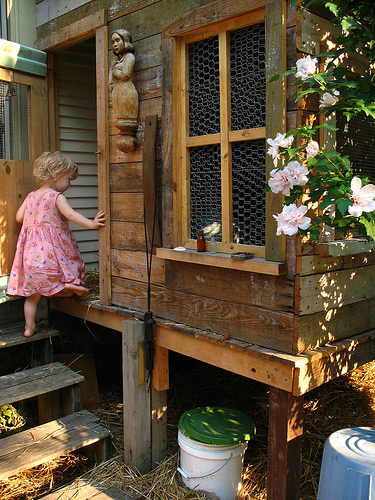

torch.Size([3, 224, 224])
torch.Size([224, 224, 3])


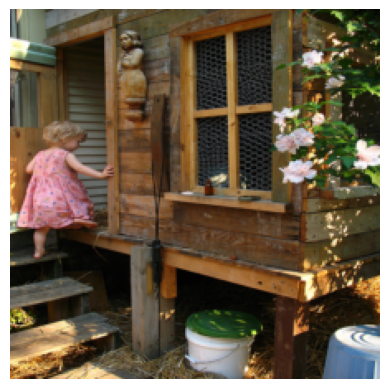

In [13]:
first = next(iter(train_ds))
print(first["caption"])
img = Image.open(first["image"])  # use Pillow's Image object
display(img)

image = feature_extractor(img).pixel_values[0]
print(image.shape)  # torch size [3, 224, 224] or [channels, height, width]

image = image.permute(1, 2, 0)  # [3,224,224] to [224,224,3]
print(image.shape)

# This image has range [-0.937, 1.0]. Normalize it to the range [0.0, 1.0]
image = (image - image.min()) / (image.max() - image.min())

plt.imshow(image)
plt.axis("off")
plt.show()

# Creating Training and Validation Datasets

In [14]:
def image_preprocess(batch, process):
    # ViT expects `pixel_values` instead of `input_ids`
    batch["pixel_values"] = [process(Image.open(path)) for path in batch["image"]]

    # We are padding tokens here instead of using a datacollator
    tokenized = tokenizer(batch["caption"], padding="max_length",
                          max_length=MAX_TOKENS,
                          truncation=True)["input_ids"]

    # Important: make sure that PAD tokens are ignored by the loss function
    labels = []
    for token_sequence in tokenized:
        new_label_sequence = []
        for label_id in token_sequence:
            if label_id == tokenizer.pad_token_id:
                new_label_sequence.append(-100)
            else:
                new_label_sequence.append(label_id)
        labels.append(new_label_sequence)

    batch["labels"] = labels

    return batch


# It is better to use dynamic augmentation on-the-fly. Use dynamice augmentation later
# image_preprocess_train = partial(image_preprocess, process=augment)  # use static augment

image_preprocess_train = partial(image_preprocess, process=process)  # without static augment
image_preprocess_valid = partial(image_preprocess, process=process)

# Get current number of threads. PyTorch uses the number of
# physical CPU cores as the default number of threads
num_threads = torch.get_num_threads()  # save default number of threads
print(f"Current number of PyTorch threads: {num_threads}")

# BUG! Using num_proc>1 in Dataset.map hangs
#      unless this parameter is set:
torch.set_num_threads(1)

train_ds = train_ds.map(image_preprocess_train, batched=True, num_proc=NUM_WORKERS)
# Don't delete "image" and "caption" columns for dynamic augmentation
# train_ds = train_ds.remove_columns(["image", "caption"])

valid_ds = valid_ds.map(image_preprocess_valid, batched=True, num_proc=NUM_WORKERS)
# Don't delete "image" and "caption" columns for dynamic augmentation
# valid_ds = valid_ds.remove_columns(["image", "caption"])

# Restore default number of threads
torch.set_num_threads(num_threads)

Current number of PyTorch threads: 6


Map (num_proc=8):   0%|          | 0/7591 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/500 [00:00<?, ? examples/s]

In [15]:
# Create dataset for convenience from training and validation parts
ds = datasets.DatasetDict({"train": train_ds, "valid": valid_ds,})
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'caption', 'pixel_values', 'labels'],
        num_rows: 7591
    })
    valid: Dataset({
        features: ['image', 'caption', 'pixel_values', 'labels'],
        num_rows: 500
    })
})


In [16]:
if os.path.exists(DS_NAME):  # delete previous dataset
    shutil.rmtree(DS_NAME, ignore_errors=False, onerror=None)

# dataset size == 23 GB and you can save it locally
ds.save_to_disk(DS_NAME)

Saving the dataset (0/10 shards):   0%|          | 0/7591 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

**Always look at you data!**

Wrong image augmentation with [`RandomResizedCrop`](https://docs.pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomResizedCrop) from [this example](https://mehdirezvandehy.github.io/Image-Captioning-by-Fine-tunning-ViT-model/Image_Caption_ViT.html#Image-Processing):

![Wrong image augmentation example with RandomResizedCrop](./data/wrong_image_augmentation.png)

I down't use `RandomResizedCrop`, because I don't understand it.

DatasetDict({
    train: Dataset({
        features: ['image', 'caption', 'pixel_values', 'labels'],
        num_rows: 7591
    })
    valid: Dataset({
        features: ['image', 'caption', 'pixel_values', 'labels'],
        num_rows: 500
    })
})


/tmp/ipykernel_2343751/2754696810.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  image = np.array(image)  # convert list to NumPy


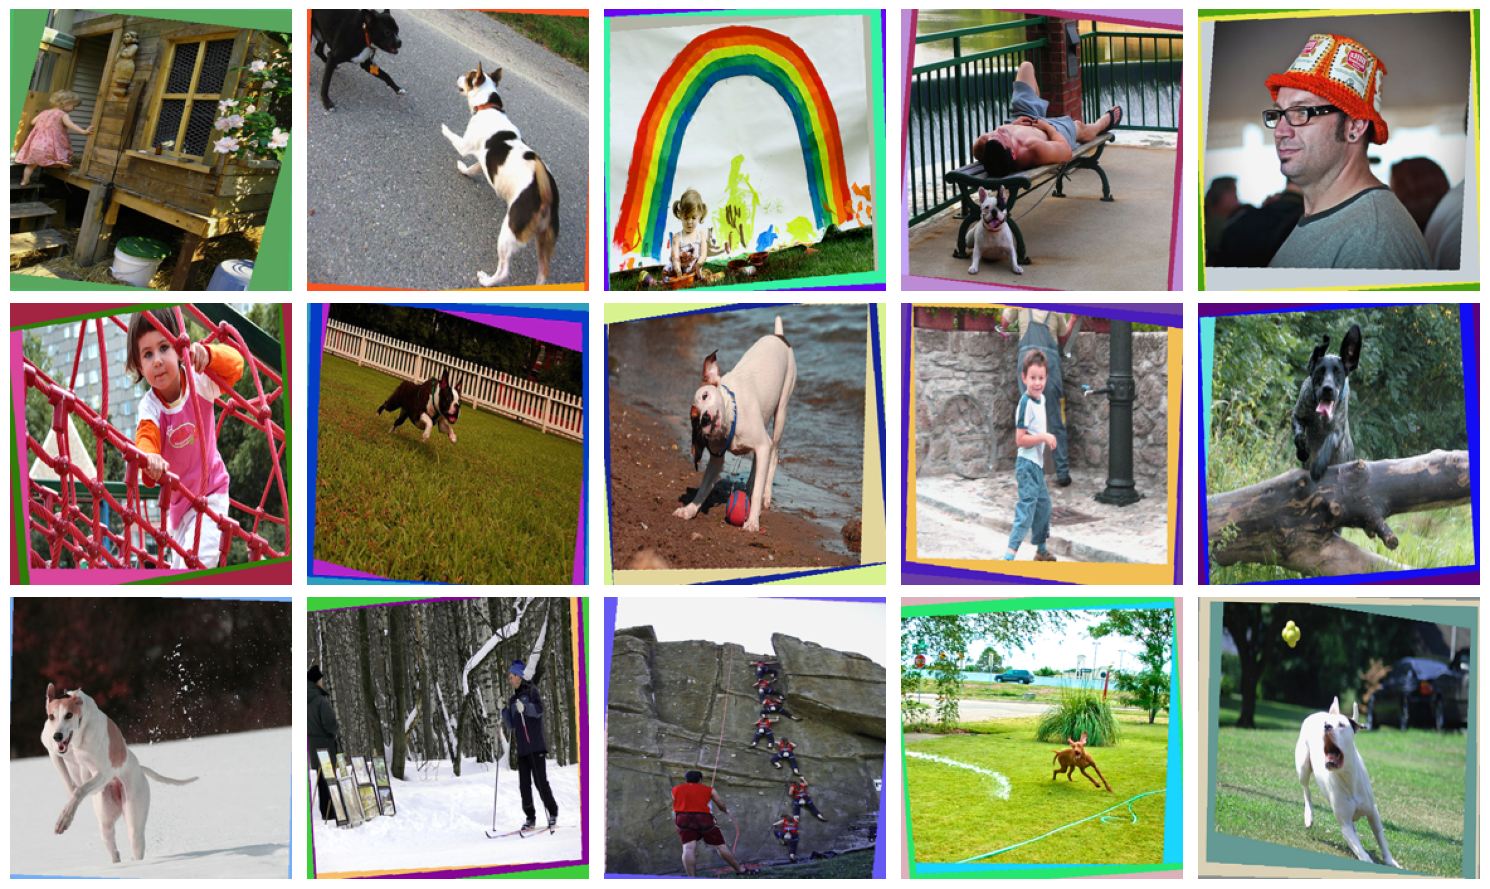

In [17]:
ds = datasets.load_from_disk(DS_NAME)  # load dataset from disk
print(ds)

# Apply dynamic augmentation "on the fly"
# set_transform modifies a dataset in-place
# with_transform returns a new dataset 
ds["train"].set_transform(dynamic_augment)  # check augmentation in-place
# ds["train"].with_transform(dynamic_augment)
# ds.set_format('torch')

# Access and display the first few images
num_samples_to_display = 15  # 3 * 5 = 15 images
rows = 1 + (num_samples_to_display - 1) // 5
cols = 5

plt.figure(figsize=(15, 9))
for i in range(num_samples_to_display):
    image = ds["train"][i]["pixel_values"]
    image = np.array(image)  # convert list to NumPy
    image = image.transpose(1, 2, 0)  # [3,224,224] to [224,224,3]
    image = (image - image.min()) / (image.max() - image.min())  # [-1,1] to [0,1]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(image)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Obtaining a Model

In [18]:
# Try to free GPU memory. This doesn't always work
if "model" in locals():
    del model
    gc.collect()
    torch.cuda.empty_cache()


try:  # trying to load a model from a checkpoint
    model = hf.VisionEncoderDecoderModel.from_pretrained(RESULTS).to(DEVICE)
except Exception as e:
    name = type(e).__name__  # error name
    print("Downloading model from the Hugging Face repository")

    # Many weights are initialized randomly, namely the cross attention weights
    model = hf.VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
        ENCODER, DECODER)
    
    # Not necessary. Huggingface automatically detect and utilize all GPUs in DataParallel
    # To disable the following warning use `.to(DEVICE)` for your model and example images:
    #   There were missing keys in the checkpoint model loaded: ['decoder.lm_head.weight'].
    model.to(DEVICE)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.2.crossattention.c_attn.bias', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.2.cr

In [19]:
# Show some technical information about encoder and decoder neural networks
display(type(model.encoder))
display(type(model.decoder))
print(f"\n{'-'*32}\n")  # print delimiter
print(model)

transformers.models.vit.modeling_vit.ViTModel

transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel


--------------------------------

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features

In [20]:
# Count total number of parameters in the model
total_params = 0
for param in model.parameters():
    total_params += param.numel()
print(f"The model has {total_params:,} parameters")

# Get the number of hidden layers in encoder (ViT) Transforver
num_hidden_layers = model.config.encoder.num_hidden_layers
print(f"The encoder Transformer has {num_hidden_layers} hidden layers")

# Get the number of hidden layers in decoder (Distilled-GPT2) Transforver
num_hidden_layers = model.config.decoder.num_hidden_layers
print(f"The decoder Transformer has {num_hidden_layers} hidden layers\n\n")

# Print all layers of the model
for name, param in model.named_parameters():
    print(name)

The model has 182,485,248 parameters
The encoder Transformer has 12 hidden layers
The decoder Transformer has 6 hidden layers


encoder.embeddings.cls_token
encoder.embeddings.position_embeddings
encoder.embeddings.patch_embeddings.projection.weight
encoder.embeddings.patch_embeddings.projection.bias
encoder.encoder.layer.0.attention.attention.query.weight
encoder.encoder.layer.0.attention.attention.query.bias
encoder.encoder.layer.0.attention.attention.key.weight
encoder.encoder.layer.0.attention.attention.key.bias
encoder.encoder.layer.0.attention.attention.value.weight
encoder.encoder.layer.0.attention.attention.value.bias
encoder.encoder.layer.0.attention.output.dense.weight
encoder.encoder.layer.0.attention.output.dense.bias
encoder.encoder.layer.0.intermediate.dense.weight
encoder.encoder.layer.0.intermediate.dense.bias
encoder.encoder.layer.0.output.dense.weight
encoder.encoder.layer.0.output.dense.bias
encoder.encoder.layer.0.layernorm_before.weight
encoder.encoder.layer.0.laye

# Preparing the Model for Training

Typically, **none of the decoder Transformer layers should be frozen** especially in generative tasks like text generation, image captioning, or machine translation.

There is no fixed number of encoder Transformer layers to freeze. It depends on the task, dataset size, and training goals. However, here are common practices:
   * **On small datasets**: Freeze early/middle layers (e.g., first 612 out of 1224), especially if using a pre-trained encoder (like BERT or ViT). Only fine-tune the top layers and task-specific heads. This prevents overfitting and saves computation while preserving general feature extraction.
   * **On large datasets**: Typically freeze none. Fine-tune all encoder layers. This allows the model to fully adapt learned representations to the new task, often yielding the best performance.
   * **In multimodal models** (e.g., **image captioning**): Often, the vision encoder (like ViT) is frozen or partially frozen, while the language encoder/decoder is trained. This is because *visual features are already well-learned from large-scale pretraining*, and only language alignment needs adjustment.

Let's consider the following options:

* Option 1. Freeze all encoder layers
* Option 2. Freeze all encoder layers except the last one
* Option 3. Unfreeze all layers of the model
* Option 4. Unfreeze all layers of the model. Make one caption from 5 different captions
* Option 5. The same as option 3, but reduce MAX_TOKENS from 50 to 20
* Option 6. The same as option 4, but increase MAX_TOKENS from 50 to 132
   * 6.1. Static augmentation (augment 1 time at the beginning)
   * 6.2. Without augmentation
   * 6.3. Augmentation on-the-fly (dynamic augmentation)
   * 6.4. ROUGE-L F1 score instead of default cross-entropy loss
* Option 7. The same as 6.4, but with texts augmentation.

In [21]:
encoder = model.encoder  # access the encoder part of the model

if OPTION == 1:
    print("Freeze all encoder layers")
    for param in encoder.parameters():
        param.requires_grad = False  # freeze

elif OPTION == 2:
    print("Freeze all encoder layers except the last one")
    for param in encoder.parameters():  # freeze all encoder layers
        param.requires_grad = False  # freeze

    # Unfreeze the parameters of the last encoder layer
    if hasattr(encoder, "encoder") and hasattr(encoder.encoder, "layer"):
        last_encoder_layer = encoder.encoder.layer[-1]
        for param in last_encoder_layer.parameters():
            param.requires_grad = True  # unfreeze
    else:
        # You might need to manually inspect the model's structure
        # if the above path is incorrect, e.g., print(model.encoder) or
        # print(model.encoder.encoder) to understand the structure.
        print(f"Could not find `encoder.encoder.layer`. "
              f"Please, adjust the path to the last layer "
              f"based on your model's architecture.")

elif OPTION in (3, 4, 5, 6, ):
    print("Unfreeze all layers of the model")
    if OPTION == 4:
        print("Make one caption from 5 different captions")
    if OPTION == 5:
        print(f"Reduce MAX_TOKENS from 50 to {MAX_TOKENS}")
    if OPTION == 6:
        print(f"Increase MAX_TOKENS from 50 to {MAX_TOKENS}")

    for param in model.parameters():
        param.requires_grad = True  # unfreeze

else:  # OPTION not set
    print(f"Warning: The variable OPTION should be equal to 1, 2, or 3, "
          f"but is equal to {OPTION}.\n")

show_trainable_layers(model)

Unfreeze all layers of the model
Increase MAX_TOKENS from 50 to 132
Number of trainable parameters = 182,485,248
Trainable layers:

encoder.embeddings.cls_token
encoder.embeddings.position_embeddings
encoder.embeddings.patch_embeddings.projection.weight
encoder.embeddings.patch_embeddings.projection.bias
encoder.encoder.layer.0.attention.attention.query.weight
encoder.encoder.layer.0.attention.attention.query.bias
encoder.encoder.layer.0.attention.attention.key.weight
encoder.encoder.layer.0.attention.attention.key.bias
encoder.encoder.layer.0.attention.attention.value.weight
encoder.encoder.layer.0.attention.attention.value.bias
encoder.encoder.layer.0.attention.output.dense.weight
encoder.encoder.layer.0.attention.output.dense.bias
encoder.encoder.layer.0.intermediate.dense.weight
encoder.encoder.layer.0.intermediate.dense.bias
encoder.encoder.layer.0.output.dense.weight
encoder.encoder.layer.0.output.dense.bias
encoder.encoder.layer.0.layernorm_before.weight
encoder.encoder.layer.0.

In [22]:
# Set token IDs in our model to be the same as GPT-2
#   [BOS] Beginning Of Sequence
#   [EOS] End Of Sequence
#   [PAD] Padding token
#   [SEP] (Separator) token often has the ID 102
#   [CLS] (Classification) token is always the first token
#         in a sequence, signaling the start of the input
#   [UNK] unknown token that doesn't exist the the vocabulary set

# Make sure the model's decoder config reflects the tokenizer
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.bos_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id

# Suppress warning:
#   Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation
model.generation_config.pad_token_id = tokenizer.pad_token_id

In [23]:
metric = evaluate.load("rouge")  # define metric

ignore_pad_token_for_loss = True


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels,
                            use_stemmer=True)
    result = {key: round(value * 100, 4) for key, value in result.items()}
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    return result


# # 1. Initialize the ROUGE scorer
# scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# # 2. Define the compute_metrics function
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     # Decode the predictions and labels
#     # For text generation, you need to convert logits to token IDs and then decode
#     predicted_ids = np.argmax(predictions, axis=-1) # Assuming predictions are logits
    
#     # Handle label padding (replace -100 with pad_token_id)
#     # You'll need access to your tokenizer here for the pad_token_id
#     # Example: labels = np.where(labels == -100, tokenizer.pad_token_id, labels)
    
#     generated_captions = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)
#     ground_truth_captions = tokenizer.batch_decode(labels, skip_special_tokens=True)

#     # Compute ROUGE scores
#     # You may want to aggregate scores instead of just taking the fmeasure of the first example
#     rougeL_scores = []
#     for pred, label in zip(generated_captions, ground_truth_captions):
#         scores = scorer.score(label, pred)
#         rougeL_scores.append(scores['rougeL'].fmeasure)
    
#     # Calculate the average ROUGE-L score
#     average_rougeL = np.mean(rougeL_scores)

#     # Return a dictionary with the metric
#     return {"rougeL": average_rougeL}


# A simple data collator if no complex batching/padding is required
# beyond what with_transform provides
def collate_fn(batch):
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.tensor([x["labels"] for x in batch])
    }


training_args = hf.Seq2SeqTrainingArguments(
    output_dir=RESULTS,          # the output directory
    overwrite_output_dir=False,  # do not overwrite the output dir
    num_train_epochs=EPOCHS,     # number of training epochs
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,  # batch size for training
    per_device_eval_batch_size=BATCH_SIZE,   # batch size for evaluation
    log_level="info",
    logging_steps=50,

    load_best_model_at_end=True,  # save the best checkpoint at the end
    save_total_limit=1,           # keep only the best model checkpoint
    
    # # Use default metrics: cross-entropy loss
    # metric_for_best_model="eval_loss", # use cross-entropy loss
    # greater_is_better=False,           # optional. Lower loss is better

    predict_with_generate=True,  # crucial for generative metrics like ROUGE
    
    # Use ROUGE-L F1 score on the validation set,
    # instead of minimizing "eval_loss"
    metric_for_best_model="eval_rougeL",  # ROUGE-L F1 score
    greater_is_better=True,

    # # IMPORTANT: Set to False to get logits for compute_metrics
    # Delete it if works --> prediction_loss_only=False,
    
    # Important for dynamic augmentation
    # Keep the 'image' column until transformations are applied
    remove_unused_columns=False,  # important for set_transform function
    
    # Disable automatic Weights & Biases logging
    report_to="none",  # or report_to=[]
)

# Training and Saving the Model

In [24]:
trainer = hf.Seq2SeqTrainer(  # set trainer
    model=model,
    args=training_args,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,  # compute ROUGE metrics
    train_dataset=ds["train"],
    eval_dataset=ds["valid"],
    data_collator=hf.default_data_collator,
    # data_collator=collate_fn, # doesn't work yet
)

In [25]:
trainer.evaluate()  # evaluate model before training


***** Running Evaluation *****
  Num examples = 500
  Batch size = 25
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


{'eval_loss': 8.480215072631836,
 'eval_model_preparation_time': 0.0087,
 'eval_rouge1': 9.8876,
 'eval_rouge2': 0.9526,
 'eval_rougeL': 8.3575,
 'eval_rougeLsum': 8.2179,
 'eval_gen_len': 20.0,
 'eval_runtime': 46.6396,
 'eval_samples_per_second': 10.72,
 'eval_steps_per_second': 0.429}

In [26]:
trainer.train()


# # Error! Old PyTorch == v2.5. Must install PyTorch >= v2.6
# #        to resume from the last checkpoint
# trainer.train(resume_from_checkpoint=True)
# trainer.train(resume_from_checkpoint=f"{RESULTS}/checkpoint-1140")

***** Running training *****
  Num examples = 7,591
  Num Epochs = 16
  Instantaneous batch size per device = 25
  Total train batch size (w. parallel, distributed & accumulation) = 25
  Gradient Accumulation steps = 1
  Total optimization steps = 4,864
  Number of trainable parameters = 182,485,248



***** Running Evaluation *****
  Num examples = 500
  Batch size = 25
Saving model checkpoint to temp/results-6/checkpoint-304
Configuration saved in temp/results-6/checkpoint-304/config.json
Configuration saved in temp/results-6/checkpoint-304/generation_config.json
Model weights saved in temp/results-6/checkpoint-304/model.safetensors
tokenizer config file saved in temp/results-6/checkpoint-304/tokenizer_config.json
Special tokens file saved in temp/results-6/checkpoint-304/special_tokens_map.json
Deleting older checkpoint [temp/results-6/checkpoint-24] due to args.save_total_limit

***** Running Evaluation *****
  Num examples = 500
  Batch size = 25
Saving model checkpoint to temp/results-6/checkpoint-608
Configuration saved in temp/results-6/checkpoint-608/config.json
Configuration saved in temp/results-6/checkpoint-608/generation_config.json
Model weights saved in temp/results-6/checkpoint-608/model.safetensors
tokenizer config file saved in temp/results-6/checkpoint-608/tokeniz

TrainOutput(global_step=4864, training_loss=2.9585923466243242, metrics={'train_runtime': 15490.5898, 'train_samples_per_second': 7.841, 'train_steps_per_second': 0.314, 'total_flos': 1.5697537161253356e+19, 'train_loss': 2.9585923466243242, 'epoch': 16.0})

In [ ]:
trainer.evaluate()  # evaluate model after training

# Results

    path: "temp/results-1/checkpoint-1824"
    val loss:  3.278 - with ROUGE-L F1 score
    epoch:     6
    Rouge1:    29.84
    Rouge2:    2.5135
    Rougel:    **25.47** - this is the main metric for now
    Rougelsum: 28.31

    GPU:            GeForce GTX 1080 Ti
    time per epoch:  min
    batch size:     25
    GPU memory:      GiB
    System memory:   GiB

## Option 1. Freeze all encoder layers

The best model:

    path: "temp/results-1/checkpoint-1900"
    val loss:  3.864
    epoch:     11
    Rouge1:    22.35
    Rouge2:    0.7817
    Rougel:    18.53
    Rougelsum: 18.54

System resources:

    GPU:            GeForce GTX TITAN X
    time per epoch: 55 min
    batch size:     100
    GPU memory:     8.8 GiB
    System memory:  11.1 GiB

Evaluation without training:

    {'eval_loss': 9.401498794555664,
     'eval_model_preparation_time': 0.0037,
     'eval_rouge1': 10.9609,
     'eval_rouge2': 0.6706,
     'eval_rougeL': 9.1676,
     'eval_rougeLsum': 9.1623,
     'eval_gen_len': 20.0,
     'eval_runtime': 240.1668,
     'eval_samples_per_second': 10.409,
     'eval_steps_per_second': 0.104}


| Epoch | Train Loss | Valid Loss | Model Prep Time | Rouge1 | Rouge2 | Rougel | Rougelsum | Gen Len |
|-------|------------|------------|-----------------|--------|--------|--------|-----------|---------|
| 1     | 4.070      | 4.360      | 0.0037          | 21.80  | 0.3243 | 19.48  | 19.50     | 20.0    |
| 2     | 3.827      | 4.192      | 0.0037          | 22.80  | 0.5268 | 19.54  | 19.54     | 20.0    |
| 3     | 3.719      | 4.152      | 0.0037          | 22.97  | 0.6284 | 19.46  | 19.45     | 20.0    |
| 4     | 3.619      | 4.052      | 0.0039          | 22.94  | 0.5304 | 19.60  | 19.59     | 20.0    |
| 5     | 3.511      | 3.990      | 0.0039          | 21.63  | 0.7762 | 18.19  | 18.20     | 20.0    |
| 6     | 3.443      | 3.978      | 0.0039          | 21.58  | 0.6607 | 18.09  | 18.09     | 20.0    |
| 7     | 3.372      | 3.949      | 0.0033          | 22.23  | 0.7098 | 18.71  | 18.71     | 20.0    |
| 8     | 3.317      | 3.903      | 0.0033          | 20.54  | 0.7372 | 17.39  | 17.40     | 20.0    |
| 9     | 3.240      | 3.886      | 0.0033          | 22.46  | 0.8211 | 18.72  | 18.73     | 20.0    |
| 10    | 3.168      | 3.865      | 0.0033          | 22.45  | 0.7149 | 18.52  | 18.51     | 20.0    |
|best 11| 3.074      | **3.864**  | 0.0033          | 22.35  | 0.7817 | 18.53  | 18.54     | 20.0    |
| 12    | 3.031      | 3.867      | 0.0033          | 20.61  | 0.7626 | 17.35  | 17.35     | 20.0    |
| 13    | 2.947      | 3.878      | 0.0033          | 22.08  | 0.7810 | 18.57  | 18.58     | 20.0    |
| 14    | 2.890      | 3.878      | 0.0033          | 21.64  | 0.7248 | 18.03  | 18.03     | 20.0    |
| 15    | 2.833      | 3.886      | 0.0033          | 22.36  | 0.7474 | 18.43  | 18.43     | 20.0    |
| 16    | 2.781      | 3.927      | 0.0033          | 21.02  | 0.6517 | 17.10  | 17.10     | 20.0    |
| 17    | 2.727      | 3.929      | 0.0033          | 22.17  | 0.7558 | 18.15  | 18.14     | 20.0    |
| 18    | 2.690      | 3.966      | 0.0033          | 21.68  | 0.7067 | 17.92  | 17.93     | 20.0    |
| 19    | 2.642      | 3.987      | 0.0033          | 22.53  | 0.7910 | 18.33  | 18.33     | 20.0    |
| 20    | 2.614      | 4.012      | 0.0033          | 22.38  | 0.6558 | 18.07  | 18.08     | 20.0    |
| 21    | 2.561      | 4.026      | 0.0033          | 21.37  | 0.7144 | 17.54  | 17.53     | 20.0    |
| 22    | 2.517      | 4.060      | 0.0033          | 22.39  | 0.7016 | 18.31  | 18.31     | 20.0    |
| 23    | 2.508      | 4.067      | 0.0033          | 21.55  | 0.6468 | 17.47  | 17.47     | 20.0    |
| 24    | 2.466      | 4.085      | 0.0033          | 22.00  | 0.7118 | 17.82  | 17.83     | 20.0    |
| 25    | 2.441      | 4.113      | 0.0033          | 22.57  | 0.6768 | 18.26  | 18.26     | 20.0    |
| 26    | 2.434      | 4.121      | 0.0033          | 22.44  | 0.7640 | 18.16  | 18.16     | 20.0    |
| 27    | 2.385      | 4.130      | 0.0033          | 21.36  | 0.6297 | 17.53  | 17.53     | 20.0    |
| 28    | 2.364      | 4.156      | 0.0033          | 21.94  | 0.7998 | 17.80  | 17.80     | 20.0    |
| 29    | 2.370      | 4.176      | 0.0033          | 21.82  | 0.6829 | 17.72  | 17.71     | 20.0    |
| 30    | 2.352      | 4.181      | 0.0033          | 21.65  | 0.6921 | 17.63  | 17.63     | 20.0    |
| 31    | 2.347      | 4.196      | 0.0033          | 21.75  | 0.6942 | 17.60  | 17.60     | 20.0    |
| 32    | 2.320      | 4.198      | 0.0033          | 21.89  | 0.6908 | 17.67  | 17.67     | 20.0    |

Without `Rouge1` metrics and with `RandomResizedCrop` augmentaton:

    Epoch 	Training Loss 	Validation Loss 	Model Preparation Time
    1 	4.077100 	3.982260 		0.009800
    2 	3.838600 	3.834445 		0.009800
    3 	3.735400 	3.797139 		0.009800


## Option 2. Freeze all encoder layers except the last one

The best model:

    path: "temp/results-2/checkpoint-2660"
    val loss:  3.875
    epoch:     7
    Rouge1:    21.89
    Rouge2:    0.8528
    Rougel:    18.61
    Rougelsum: 18.61

System resources:

    GPU:            GeForce GTX 1080 Ti
    time per epoch: 50 min
    batch size:     100
    GPU memory:     9.8 GiB
    System memory:  11.1 GiB

Evaluation without training:

    {'eval_loss': 5.6199164390563965,
     'eval_model_preparation_time': 0.004,
     'eval_rouge1': 16.6046,
     'eval_rouge2': 1.1628,
     'eval_rougeL': 13.1714,
     'eval_rougeLsum': 13.1793,
     'eval_gen_len': 20.0,
     'eval_runtime': 214.0398,
     'eval_samples_per_second': 11.68,
     'eval_steps_per_second': 0.117}


| Epoch | Train Loss | Valid Loss | Model Prep Time | Rouge1 | Rouge2 | Rougel | Rougelsum | Gen Len |
|-------|------------|------------|-----------------|--------|--------|--------|-----------|---------|
| 1     | 3.985      | 4.270      | 0.004           | 21.88  | 0.4221 | 19.12  | 19.12     | 20.0    |
| 2     | 3.679      | 4.071      | 0.004           | 20.66  | 0.5120 | 17.56  | 17.56     | 20.0    |
| 3     | 3.493      | 3.976      | 0.004           | 20.59  | 0.6132 | 17.37  | 17.36     | 20.0    |
| 4     | 3.368      | 3.910      | 0.004           | 21.55  | 0.7771 | 18.02  | 18.03     | 20.0    |
| 5     | 3.239      | 3.886      | 0.004           | 22.31  | 0.9343 | 18.58  | 18.59     | 20.0    |
| 6     | 3.166      | 3.878      | 0.004           | 20.68  | 0.7047 | 17.52  | 17.52     | 20.0    |
|best 7 | 3.057      | **3.875**  | 0.004           | 21.89  | 0.8528 | 18.61  | 18.61     | 20.0    |
| 8     | 2.982      | 3.881      | 0.004           | 20.72  | 0.6773 | 17.29  | 17.30     | 20.0    |
| 9     | 2.893      | 3.900      | 0.004           | 21.51  | 0.8518 | 17.89  | 17.90     | 20.0    |
| 10    | 2.815      | 3.936      | 0.004           | 21.76  | 0.6937 | 17.78  | 17.78     | 20.0    |
| 11    | 2.744      | 3.962      | 0.004           | 21.31  | 0.6021 | 17.74  | 17.75     | 20.0    |
| 12    | 2.684      | 4.008      | 0.004           | 21.39  | 0.7786 | 17.71  | 17.70     | 20.0    |
| 13    | 2.621      | 4.044      | 0.004           | 20.99  | 0.7117 | 17.11  | 17.12     | 20.0    |
| 14    | 2.572      | 4.112      | 0.004           | 21.71  | 0.7766 | 17.70  | 17.71     | 20.0    |
| 15    | 2.494      | 4.152      | 0.004           | 21.87  | 0.8325 | 17.71  | 17.71     | 20.0    |
| 16    | 2.431      | 4.188      | 0.004           | 22.19  | 0.8707 | 18.20  | 18.20     | 20.0    |


## Option 3. Unfreeze all layers of the model

The best model:

    path: "temp/results-3/checkpoint-2847"
    val loss:  3.853
    epoch:     3
    Rouge1:    24.76
    Rouge2:    0.9882
    Rougel:    20.44
    Rougelsum: 20.44

System resources:

    GPU:            GeForce GTX TITAN X
    time per epoch: 74 min
    batch size:     40
    GPU memory:     10.5 GiB
    System memory:  8.7 GiB

Evaluation without training:

    {'eval_loss': 9.400985717773438,
     'eval_model_preparation_time': 0.0045,
     'eval_rouge1': 10.9609,
     'eval_rouge2': 0.6706,
     'eval_rougeL': 9.1676,
     'eval_rougeLsum': 9.1623,
     'eval_gen_len': 20.0,
     'eval_runtime': 256.4259,
     'eval_samples_per_second': 9.749,
     'eval_steps_per_second': 0.246}


| Epoch | Train Loss | Valid Loss | Model Prep Time | Rouge1 | Rouge2 | Rougel | Rougelsum | Gen Len |
|-------|------------|------------|-----------------|--------|--------|--------|-----------|---------|
| 1     | 3.705      | 4.102      | 0.0045          | 23.06  | 0.9606 | 19.58  | 19.57     | 20.0    |
| 2     | 3.411      | 3.912      | 0.0045          | 23.58  | 0.7694 | 19.47  | 19.47     | 20.0    |
|best 3 | 3.145      | **3.853**  | 0.0045          | 24.76  | 0.9882 | 20.44  | 20.44     | 20.0    |
| 4     | 2.885      | 3.901      | 0.0045          | 24.08  | 0.8212 | 19.81  | 19.81     | 20.0    |
| 5     | 2.689      | 4.006      | 0.0045          | 24.42  | 0.8536 | 19.86  | 19.86     | 20.0    |
| 6     | 2.450      | 4.205      | 0.0045          | 22.55  | 0.7631 | 18.29  | 18.30     | 20.0    |
| 7     | 2.232      | 4.420      | 0.0045          | 22.58  | 0.6779 | 18.28  | 18.28     | 20.0    |
| 8     | 1.991      | 4.790      | 0.0045          | 22.60  | 0.6153 | 18.03  | 18.03     | 20.0    |
| 9     | 1.807      | 5.051      | 0.0045          | 22.97  | 0.6608 | 18.34  | 18.34     | 20.0    |
| 10    | 1.644      | 5.442      | 0.0045          | 22.11  | 0.7197 | 17.75  | 17.74     | 20.0    |


## Option 4. Unfreeze all layers of the model. Make one caption from 5 different captions

The best model:

    path: "temp/results-4/checkpoint-950"
    val loss:  3.429
    epoch:     5
    Rouge1:    28.49
    Rouge2:    1.7744
    Rougel:    24.78
    Rougelsum: 27.01

System resources:

    GPU:            GeForce GTX TITAN X
    time per epoch: 16 min
    batch size:     40
    GPU memory:     10.5 GiB
    System memory:  8.7 GiB


| Epoch | Train Loss | Valid Loss | Model Prep Time | Rouge1 | Rouge2 | Rougel | Rougelsum | Gen Len |
|-------|------------|------------|-----------------|--------|--------|--------|-----------|---------|
| 1     | 3.927      | 3.792      | 0.0079          | 27.28  | 1.0652 | 25.23  | 26.72     | 20.0    |
| 2     | 3.582      | 3.610      | 0.0079          | 29.68  | 1.4507 | 25.86  | 28.70     | 20.0    |
| 3     | 3.428      | 3.501      | 0.0079          | 29.12  | 1.5645 | 25.80  | 28.29     | 20.0    |
| 4     | 3.271      | 3.460      | 0.0079          | 31.55  | 1.8716 | 26.72  | 30.09     | 20.0    |
|best 5 | 3.133      | **3.429**  | 0.0079          | 28.49  | 1.7744 | 24.78  | 27.01     | 20.0    |
| 6     | 3.030      | 3.430      | 0.0079          | 31.69  | 2.0999 | 26.98  | 29.99     | 20.0    |
| 7     | 2.929      | 3.441      | 0.0079          | 30.25  | 2.0315 | 25.80  | 28.44     | 20.0    |
| 8     | 2.838      | 3.464      | 0.0079          | 31.95  | 2.2662 | 26.83  | 30.01     | 20.0    |
| 9     | 2.760      | 3.505      | 0.0079          | 31.31  | 2.3112 | 26.09  | 29.34     | 20.0    |
| 10    | 2.670      | 3.556      | 0.0079          | 30.73  | 2.3346 | 25.80  | 28.92     | 20.0    |
| 11    | 2.566      | 3.619      | 0.0079          | 30.79  | 2.2847 | 25.55  | 28.78     | 20.0    |
| 12    | 2.478      | 3.698      | 0.0079          | 31.43  | 2.4537 | 26.00  | 29.28     | 20.0    |
| 13    | 2.420      | 3.767      | 0.0079          | 31.52  | 2.4108 | 25.90  | 29.33     | 20.0    |
| 14    | 2.318      | 3.869      | 0.0079          | 31.19  | 2.3768 | 25.48  | 29.27     | 20.0    |
| 15    | 2.255      | 3.971      | 0.0079          | 30.33  | 2.3828 | 25.02  | 28.37     | 20.0    |
| 16    | 2.196      | 4.073      | 0.0079          | 30.44  | 2.3379 | 24.90  | 28.56     | 20.0    |

## Option 5. The same as option 3, but reduce MAX_TOKENS from 50 to 20

The best model:

    path: "temp/results-4/checkpoint-2847"
    val loss:  3.874
    epoch:     3
    Rouge1:    24.63
    Rouge2:    0.9694
    Rougel:    20.35
    Rougelsum: 20.35

System resources:

    GPU:            GeForce GTX TITAN X
    time per epoch: 66 min
    batch size:     40
    GPU memory:     8.6 GiB
    System memory:  8.0 GiB


| Epoch | Train Loss | Valid Loss | Model Prep Time | Rouge1 | Rouge2 | Rougel | Rougelsum | Gen Len |
|-------|------------|------------|-----------------|--------|--------|--------|-----------|---------|
| 1     | 3.703      | 4.098      | 0.0070          | 23.42  | 0.9370 | 20.08  | 20.09     | 20.0    |
| 2     | 3.419      | 3.911      | 0.0070          | 23.60  | 0.7384 | 19.36  | 19.37     | 20.0    |
|best 3 | 3.151      | **3.874**  | 0.0070          | 24.63  | 0.9694 | 20.35  | 20.35     | 20.0    |
| 4     | 2.903      | 3.901      | 0.0070          | 24.00  | 0.7300 | 19.76  | 19.75     | 20.0    |
| 5     | 2.699      | 4.032      | 0.0070          | 23.26  | 0.7618 | 18.78  | 18.78     | 20.0    |
| 6     | 2.498      | 4.215      | 0.0070          | 21.29  | 0.7503 | 17.51  | 17.51     | 20.0    |
| 7     | 2.268      | 4.441      | 0.0070          | 22.97  | 0.7909 | 18.69  | 18.70     | 20.0    |
| 8     | 2.063      | 4.738      | 0.0070          | 21.72  | 0.8278 | 17.53  | 17.54     | 20.0    |


## Option 6. The same as option 4, but increase MAX_TOKENS from 50 to 132

### 6.1. With static augmentation. Augment only 1 time at the beginning of the training
    path: "temp/results-4/checkpoint-1824"
    val loss:  3.3687 - with static augmentation
    epoch:     6
    Rouge1:    29.57
    Rouge2:    2.3208
    Rougel:    25.21
    Rougelsum: 28.00

### 6.2. Without augmentation
    path: "temp/results-4/checkpoint-1824"
    val loss:  3.305 - without augmentation
    epoch:     6
    Rouge1:    29.78
    Rouge2:    2.4775
    Rougel:    25.12
    Rougelsum: 28.11

### 6.3. Dynamic augmentation on-the-fly during training
    path: "temp/results-1/checkpoint-2432"
    val loss:  3.270 - dynamic augmentation on-the-fly during training
    epoch:     8
    Rouge1:    28.12 	 	
    Rouge2:    2.0994
    Rougel:    23.82
    Rougelsum: 26.96

### 6.4. ROUGE-L F1 score instead of default cross-entropy loss ("eval_loss")
    path: "temp/results-1/checkpoint-1824"
    val loss:  3.278 - with ROUGE-L F1 score
    epoch:     6
    Rouge1:    29.84
    Rouge2:    2.5135
    Rougel:    **25.47** - this is the main metric for now
    Rougelsum: 28.31


System resources:

    GPU:            GTX 1080 Ti
    time per epoch: 13.5 - 16.5 min
    batch size:     25
    GPU memory:     10.2 GiB
    System memory:  7.7 - 8.0 GiB


| Epoch | Train Loss | Valid Loss | Model Prep Time | Rouge1 | Rouge2 | Rougel | Rougelsum | Gen Len |
|-------|------------|------------|-----------------|--------|--------|--------|-----------|---------|
| 1     | 3.706      | 3.635     | 0.0087           | 27.49  | 0.7554 | 24.17  | 26.75     | 20.0    |
| 2     | 3.432      | 3.467     | 0.0087           | 28.50  | 1.6885 | 24.61  | 27.10     | 20.0    |
| 3     | 3.333      | 3.377     | 0.0087           | 27.89  | 2.0856 | 24.34  | 26.50     | 20.0    |
| 4     | 3.177      | 3.327     | 0.0087           | 29.16  | 2.2739 | 24.80  | 27.44     | 20.0    |
| 5     | 3.099      | 3.298     | 0.0087           | 28.21  | 2.2799 | 24.10  | 26.78     | 20.0    |
|best 6 | 3.029      | 3.278     | 0.0087           | 29.84  | 2.5135 |**25.47**| 28.31    | 20.0    |
| 7     | 2.950      | 3.281     | 0.0087           | 28.37  | 2.4479 | 24.27  | 26.93     | 20.0    |
| 8     | 2.877      | 3.270     | 0.0087           | 28.12  | 2.0994 | 23.82  | 26.96     | 20.0    |
| 9     | 2.835      | 3.277     | 0.0087           | 29.20  | 2.5044 | 24.61  | 27.57     | 20.0    |
| 10    | 2.771      | 3.279     | 0.0087           | 29.25  | 2.4859 | 24.75  | 27.74     | 20.0    |



In [27]:
# Save the current (not the best) state of the model within the Trainer
trainer.save_model(RESULTS)  # save model checkpoint to RESULTS

Saving model checkpoint to temp/results-6
Configuration saved in temp/results-6/config.json
Configuration saved in temp/results-6/generation_config.json
Model weights saved in temp/results-6/model.safetensors
tokenizer config file saved in temp/results-6/tokenizer_config.json
Special tokens file saved in temp/results-6/special_tokens_map.json


# Examples

To run just the examples, run the **Helper Functions and Libraries** at the beginning of this Jupyter Notebook and come back here.

In [28]:
# # I don't know how to view the best checkpoint
# # Thus evaluate every checkpoint
# num = [380, 760, 1140, 1520, 1900, 2280, 2660, 3040, 3420,
#        3800, 4180, 4560, 4940, 5320, 5700, 6080, 6460, 6840,
#        7220, 7600, 7980, 8360, 8740, 9120, 9500, 9880,]

# for n in num:
#     path = f"{RESULTS}/checkpoint-{n}/"
#     print(f"Evaluate model: {path}")
#     model = hf.VisionEncoderDecoderModel.from_pretrained(path).to(DEVICE)

#     trainer = hf.Seq2SeqTrainer(
#         model=model,
#         args=training_args,
#         processing_class=tokenizer,
#         compute_metrics=compute_metrics,
#         train_dataset=ds["train"],
#         eval_dataset=ds["valid"],
#         data_collator=hf.default_data_collator,
#     )

#     metrics = trainer.evaluate()
#     eval_loss = metrics["eval_loss"]
#     print(f"Validation loss: {eval_loss}")

In [44]:
# Loading model and config from pretrained folder

# path = f"{RESULTS}/checkpoint-1824/"
# model = hf.VisionEncoderDecoderModel.from_pretrained(path).to(DEVICE)

model = hf.VisionEncoderDecoderModel.from_pretrained(RESULTS).to(DEVICE)

loading configuration file temp/results-6/checkpoint-1824/config.json
Model config VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "bos_token_id": 50256,
  "decoder": {
    "_name_or_path": "distilgpt2",
    "_num_labels": 1,
    "activation_function": "gelu_new",
    "add_cross_attention": true,
    "architectures": [
      "GPT2LMHeadModel"
    ],
    "attn_pdrop": 0.1,
    "dtype": "float32",
    "embd_pdrop": 0.1,
    "id2label": {
      "0": "LABEL_0"
    },
    "initializer_range": 0.02,
    "is_decoder": true,
    "label2id": {
      "LABEL_0": 0
    },
    "layer_norm_epsilon": 1e-05,
    "model_type": "gpt2",
    "n_ctx": 1024,
    "n_embd": 768,
    "n_head": 12,
    "n_inner": null,
    "n_layer": 6,
    "n_positions": 1024,
    "reorder_and_upcast_attn": false,
    "resid_pdrop": 0.1,
    "scale_attn_by_inverse_layer_idx": false,
    "scale_attn_weights": true,
    "summary_activation": null,
    "summary_first_dropout": 0.1,
    "su

In [45]:
# not finetuned model
non_finetuned = hf.VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    ENCODER, DECODER).to(DEVICE)

loading configuration file config.json from cache at /home/pavlenko/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/b4569560a39a0f1af58e3ddaf17facf20ab919b0/config.json
Model config ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "transformers_version": "4.57.1"
}

loading weights file model.safetensors from cache at /home/pavlenko/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/b4569560a39a0f1af58e3ddaf17facf20ab919b0/model.safetensors
loading configuration file config.json from cache at /home

In [46]:
feature_extractor = hf.AutoImageProcessor.from_pretrained(ENCODER, use_fast=True)

normalize = t.Normalize(
    mean=feature_extractor.image_mean,
    std=feature_extractor.image_std
)

# It is generally NOT recommended to use data augmentation on the validation set
process_valid = t.Compose([
    t.Resize(list(feature_extractor.size.values()),
             interpolation=t.InterpolationMode.BICUBIC),
    t.ToTensor(),  # convert to pytorch tensor
    normalize,  # normalize pixel values
])

tokenizer = hf.GPT2TokenizerFast.from_pretrained(DECODER)

# GPT2 only has bos/eos tokens but not decoder_start/pad tokens
tokenizer.pad_token = tokenizer.eos_token  # pad with EOS token

NUM_BEAMS = 5  # number of captions to the image


def read_csv(csv_file):
    """ Read CSV file and return dictionary of
        keys (image path) and values (image captions) """
    captions = {}  # dictionary of keys (image path) and values (image captions)
    df = pd.read_csv(csv_file)
    
    for row in df.itertuples():
        path, caption = row.image, row.caption
        if path in captions:
            captions[path].append(caption)
        else:
            captions[path] = [caption]
    
    return captions


def get_key_value(captions, num):
    """ Get key-value pair from the dictionary """
    iterator = iter(captions.items())
    key_value = next(islice(iterator, num, num + 1), None)
    return key_value


def predict_captions(model, path,
                     num_beams=NUM_BEAMS,
                     max_new_tokens=16,  # MAX_TOKENS ??
                     top_k=1,
                     num_return_sequences=NUM_BEAMS,
                     show=True,
                     message="Predicted captions:",
    ):
    """ Helper function for getting image captions from the Internet or from a file path """
    if path.startswith("https://"):  # download from the Internet
        response = requests.get(path)
        img = Image.open(BytesIO(response.content))
        image_matrix = process_valid(img).unsqueeze(0)
    else:  # from the file path
        img = Image.open(path)
        image_matrix = process_valid(img).unsqueeze(0)

    generated = model.generate(
        image_matrix.to(DEVICE),
        pad_token_id=tokenizer.eos_token_id,
        num_beams=num_beams,
        max_new_tokens=max_new_tokens,
        early_stopping=True,
        do_sample=True,
        top_k=top_k,
        num_return_sequences=num_return_sequences,
    )

    preds = [tokenizer.decode(g, skip_special_tokens=True).strip() for g in generated]

    display(img) if show else None
    print(f"\n{message}\t", *preds, sep="\n\t")


captions_val = read_csv(VALID_CSV)

loading configuration file preprocessor_config.json from cache at /home/pavlenko/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/b4569560a39a0f1af58e3ddaf17facf20ab919b0/preprocessor_config.json
loading configuration file config.json from cache at /home/pavlenko/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/b4569560a39a0f1af58e3ddaf17facf20ab919b0/config.json
Model config ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "transformers_version": "4.57.1"
}

loading configuration file preprocesso

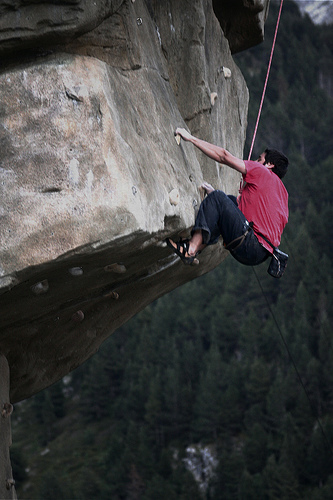


Predicted captions:	
	man a is climbing a wall a . man a climbing . man a climbing .
	man a is climbing a face a . man a climbing . man a climbing .
	man a is climbing a wall a . man a climbing . man a is climbing
	man a is climbing a wall a . man a climbing . man a is a
	man a climbing is a . man a climbing . man a climbing . man rock

Ground truth captions:	
	a man in a pink shirt climbs a rock face . a man is rock climbing high in the air . a person in a red shirt climbing up a rock face covered in assist handles . a rock climber in a red shirt . a rock climber practices on a rock climbing wall .

Untrained model:	
	The U.S. Department of Homeland Security (DHS) has issued a
	The U.S. Department of Homeland Security (DHS) is investigating a
	The U.S. Department of Homeland Security (DHS) is investigating the
	The U.S. Department of Homeland Security (DHS) is looking to
	The U.S. Department of Homeland Security (DoD) has issued an


In [47]:
path, descriptions = get_key_value(captions_val, 0)
predict_captions(model, path)
print("\nGround truth captions:\t", *descriptions, sep="\n\t")
predict_captions(non_finetuned, path, show=False, message="Untrained model:")

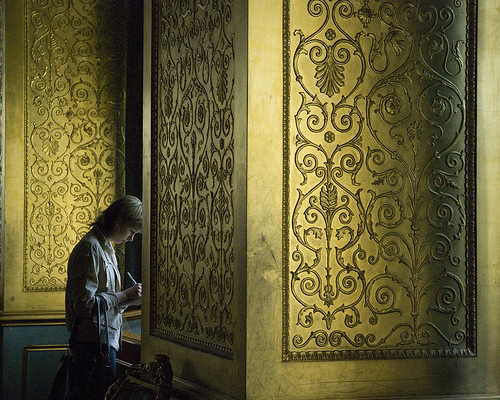


Predicted captions:	
	man a is a in costume a in costume a in . man a in costume
	man a is a in costume a in costume a in . man a in is
	man a is a in costume a in costume a in . man in costume a
	man a is a in costume a is in of building a . man a in
	man a is a in costume a in costume a in . man in costume in

Ground truth captions:	
	a person stands near golden walls . a woman behind a scrolled wall is writing . a woman standing near a decorated wall writes . the walls are covered in gold and patterns . woman writing on a pad in room with gold , decorated walls .


In [48]:
path, descriptions = get_key_value(captions_val, 1)
predict_captions(model, path)
print("\nGround truth captions:\t", *descriptions, sep="\n\t")

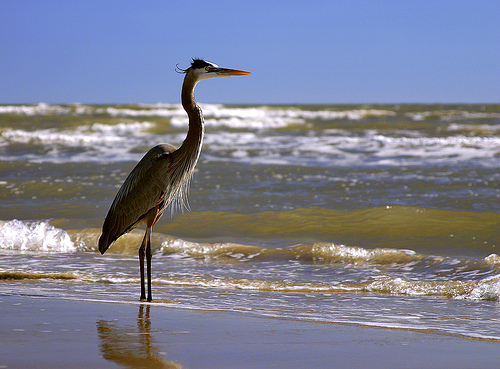


Predicted captions:	
	black white is on beach to the . black white on beach to the . black
	black white is on beach to the . black white on beach to ocean black white
	black white is on beach to the . black white on beach to the . white
	black white is on beach to the . black white on beach the is the on
	black white is on beach to the . black white on beach to ocean the .

Ground truth captions:	
	a grey bird stands majestically on a beach while waves roll in . a large bird stands in the water on the beach . a tall bird is standing on the sand beside the ocean . a water bird standing at the ocean 's edge . a white crane stands tall as it looks out upon the ocean .


In [49]:
path, descriptions = get_key_value(captions_val, 2)
predict_captions(model, path)
print("\nGround truth captions:\t", *descriptions, sep="\n\t")

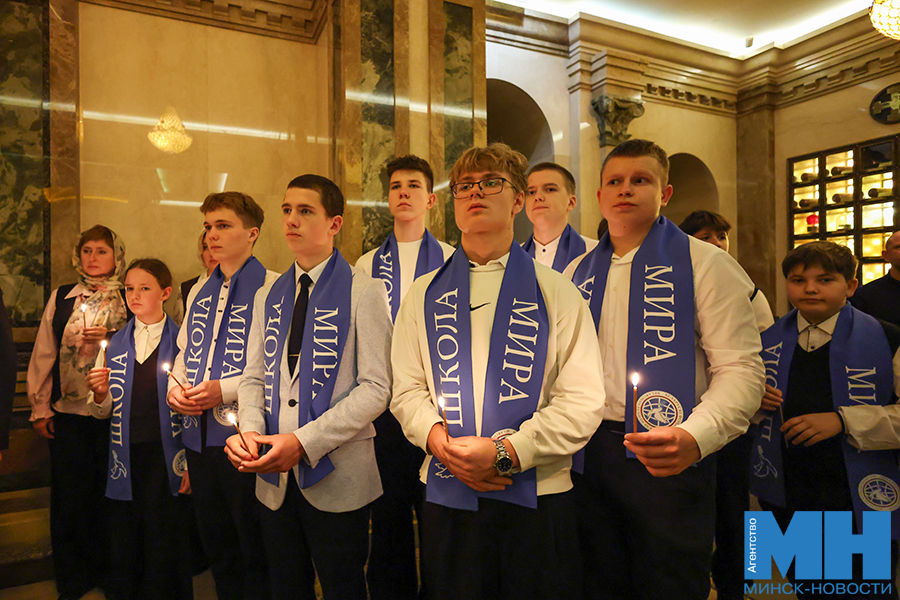


Predicted captions:	
	man a wearing black a shirt black white a shirt black white a shirt black white
	man a wearing black a shirt black white a shirt black white white black white black
	man a wearing white a shirt a shirt black white a shirt black white a shirt
	man a wearing black a shirt black white a shirt black white a and shirt a
	man a wearing black a shirt black white a shirt black white white a and a


In [50]:
path = "https://minsknews.by/wp-content/uploads/2025/10/120a8130-kopiya.jpg"
predict_captions(model, path)

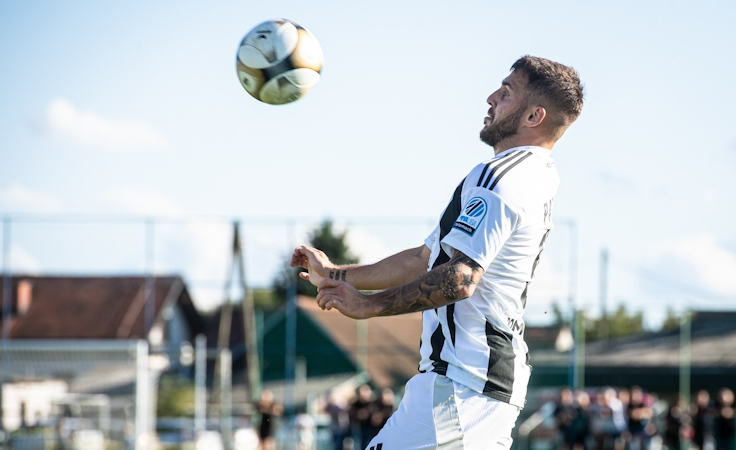


Predicted captions:	
	man a player the player the is in is the . man the player the is
	man a player the player the is in is the . man the is a player
	man a player the player the is in is the . man a player a uniform
	man a player the player the is in is the . player the is the in
	man a player the player the is in is the . man the is a in


In [51]:
path = "https://football.by/storage/images/post_img/1759599441.jpg"
predict_captions(model, path)

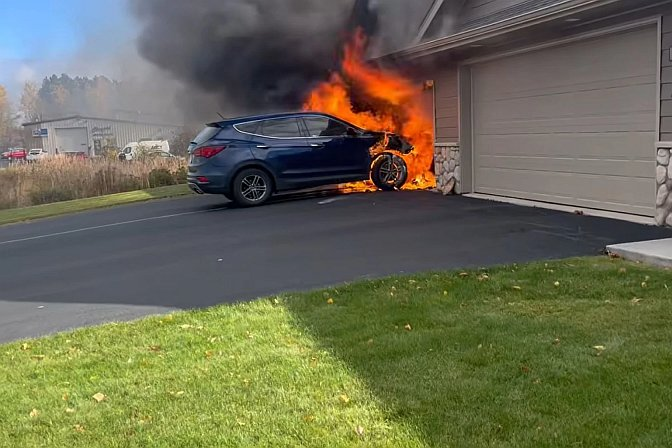


Predicted captions:	
	black white jumping a car a inair a in of . black white jumping car
	black white jumping a car a inair a in of . black white jumping a
	black white jumping a car a inair a car a in . black white jumping
	black white jumping a car a inair a car a inair a car a
	black white jumping a car a inair a in of . black white in air


In [52]:
path = "https://raw.githubusercontent.com/foobar167/junkyard/refs/heads/master/fine_tuning/data/test_image_02.jpg"
predict_captions(model, path)

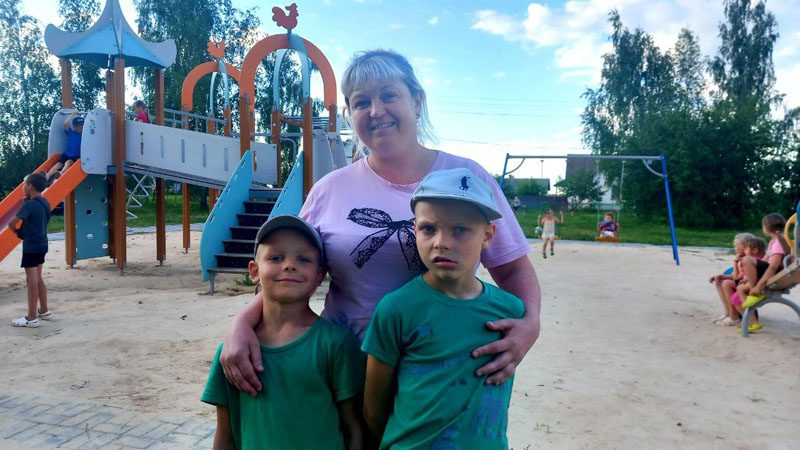


Predicted captions:	
	boy a boy a boy a boy a are on playground . boy boy boy boy
	boy a boy a boy a boy a are on playground . boy boy boy a
	boy a boy a boy a and boy playing a on playground a boy a and
	boy a boy a boy a and boy playing a . boy boy boy boy a
	boy a boy a boy a and boy playing a on playground a boy a boy


In [53]:
path = "https://raw.githubusercontent.com/foobar167/junkyard/refs/heads/master/fine_tuning/data/test_image_03.jpg"
predict_captions(model, path)

# Conclusions

* Option 1. Freeze all encoder layers
* Option 2. Freeze all encoder layers except the last one
* Option 3. Unfreeze all layers of the model
* Option 4. Unfreeze all layers of the model. Make one caption from 5 different captions
* Option 5. The same as option 3, but reduce MAX_TOKENS from 50 to 20
* Option 6. The same as option 4, but increase MAX_TOKENS from 50 to 132
   * 6.1. Static augmentation (augment 1 time at the beginning)
   * 6.2. Without augmentation
   * 6.3. Augmentation on-the-fly (dynamic augmentation)
   * 6.4. ROUGE-L F1 score instead of default cross-entropy loss
* Option 7. The same as 6.4, but with texts augmentation.


| Option | Val. loss | Epoch | Rouge1 | Rouge2 | Rougel | Rougelsum | min/epoch | GPU model   | Batch | Mem, GiB | RAM, GiB |
| ------ | --------- | ----- | ------ | ------ | ------ | --------- | --------- | ----------- | ----- | -------- | -------- |
| 1      | 3.864     | 11    | 22.35  | 0.7817 | 18.53  | 18.54     | 55        | GTX TITAN X | 100   | 8.8      | 11.1     |
| 2      | 3.875     | 7     | 21.89  | 0.8528 | 18.61  | 18.61     | 50        | GTX 1080 Ti | 100   | 9.8      | 11.1     |
| 3      | 3.853     | 3     | 24.76  | 0.9882 | 20.44  | 20.44     | 74        | GTX TITAN X | 40    | 10.5     | 8.7      |
| 4      | 3.429     | 5     | 28.49  | 1.7744 | 24.78  | 27.01     | 14        | GTX TITAN X | 40    | 10.5     | 8.7      |
| 5      | 3.874     | 3     | 24.63  | 0.9694 | 20.35  | 20.35     | 66        | GTX TITAN X | 40    | 8.6      | 8.0      |
| 6.1    | 3.369     | 6     | 29.57  | 2.3208 | 25.21  | 28.00     | 13.5      | GTX 1080 Ti | 25    | 10.2     | 7.7      |
| 6.2    | 3.305     | 6     | 29.78  | 2.4775 | 25.12  | 28.11     | 13.5      | GTX 1080 Ti | 25    | 10.2     | 7.7      |
| 6.3    | 3.270     | 8     | 28.12  | 2.0994 | 23.82  | 26.96     | 16.5      | GTX 1080 Ti | 25    | 10.2     | 8.0      |
|**best** 6.4| 3.278 | 6     | 29.84  | 2.5135 |**25.47**| 28.31    | 16.5      | GTX 1080 Ti | 25    | 10.2     | 8.0      |
| 7      |           |       |        |        |        |           |           |             |       |          |          |
| 8      |           |       |        |        |        |           |           |             |       |          |          |





   01. Don't use older GPUs for modern tasks, such as the NVIDIA GeForce GTX 1080 Ti and NVIDIA GeForce GTX TITAN X. Even if the necessary libraries are present, they are full of bugs, and no one will fix them, as technical support for older GPUs has ended.
   01. The Flickr8k dataset with 8,091 image-text examples (5 pairs for each example) is **too small** even for fine-tuning the model.
       * Try Flickr30k dataset consisting of 30,000 images that are each paired with 5 different captions. Links: [Huggingface](https://huggingface.co/datasets/nlphuji/flickr30k), [GitHub](https://github.com/awsaf49/flickr-dataset), [Kaggle](https://www.kaggle.com/datasets/adityajn105/flickr30k).
       * Try COCO dataset consisting of 330,000 images that are each paired with 5 different captions. Links: [Huggingface](https://huggingface.co/datasets/HuggingFaceM4/COCO), [Kaggle](https://www.kaggle.com/datasets/nikhil7280/coco-image-caption), [Homepage](https://cocodataset.org/#home).
   01. Important for training:
       * The longer the caption string, the better. Thus, make 1 caption from 5 different captions and increase number of tokens to the maximum.
   01. Insignificant (**not** important). However, for these options the result is slightly better:
       * Freezing layers.
       * Augmentation of images.
       * Replacing the default cross-entropy metric with other metrics. 
   01. 

# Clear Resources and Restarting the Kernel

In [ ]:
# %%script echo "Skip this cell"

# Clean up resources. Place this code at the end of the program
import os, signal
os.kill(os.getpid(), signal.SIGTERM)  # you can use signal.SIGKILL for Linux, but not for Windows